The goal of this notebook is to implement the Bayesian LASSO method for a 1D problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import recipinvgauss, invgamma
import scipy.sparse as sps
from scipy.sparse.linalg import cg

from fastprogress import progress_bar

from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

from runningstatistics import StatsTracker
import jlinops
import sampi

# Make toy problem

In [2]:
# #ground_truth = jlinops.piecewise_constant_1d_test_problem()
# ground_truth = jlinops.comp_emp_bayes_t1d_test_problem()
# n = len(ground_truth)
# np.random.seed(0)
# noise_stdev = 0.05
# noise_var = noise_stdev**2
# blur_sigma = 4.0
# blur_op = jlinops.Gaussian1DBlurOperator(n, blur_sigma=blur_sigma, mode="constant")
# noisy_signal = blur_op.matvec(ground_truth) + noise_stdev*np.random.normal(size=n)
# grid = np.arange(n)


ground_truth = jlinops.piecewise_constant_1d_test_problem()
n = len(ground_truth)
np.random.seed(0)
grid = np.arange(n)

In [3]:
# Define forward operator and regularization matrix
_F = jlinops.Gaussian1DBlurOperator( n, blur_sigma=5.0, mode="constant")
F = jlinops.MatrixLinearOperator( jlinops.black_box_to_dense(_F) )
R, _ = jlinops.first_order_derivative_1d(n, boundary="none")
R = jlinops.MatrixLinearOperator(R)

#noise_stdev = 0.05
#noise_var = noise_stdev**2

noise_var = np.power(10, -30/10)*(np.linalg.norm(F.matvec(ground_truth))**2)/F.shape[0]
noise_stdev = np.sqrt(noise_var)

np.random.seed(0)
noisy_signal = F.matvec(ground_truth) + noise_stdev*np.random.normal(size=n)

# Set regularization lambda
reg_lambda = 5*1e0

In [4]:
noise_var

0.0034351573665829943

In [5]:
10*np.log10( (np.linalg.norm(F.matvec(ground_truth))**2)/ (F.shape[0]*noise_var) )

30.0

In [6]:
10*np.log10( (np.linalg.norm(F.matvec(ground_truth))**2)/ (F.shape[0]*30) ) 

-9.41174617582265

In [7]:
np.power(10, -30/10)*(np.linalg.norm(F.matvec(ground_truth))**2)/F.shape[0]

0.0034351573665829943

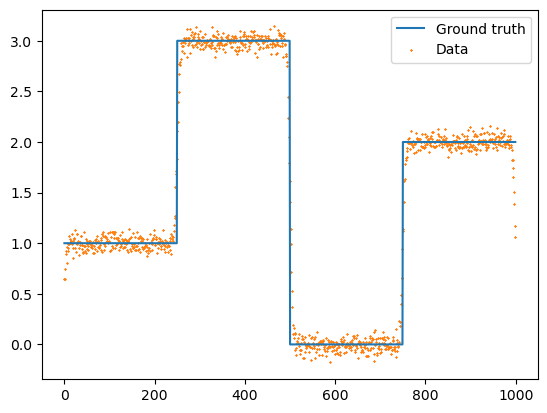

In [9]:
plt.plot(grid, ground_truth, label="Ground truth", color="C0")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.legend()
plt.show()

# MAP estimate of the L1 problem

By L1 problem, I mean solving
$$
\operatorname{argmin}_x \left\{ \frac{1}{2 \sigma^2} \| x - y \|_2^2 + \lambda \| R x \|_1 \right\} = \operatorname{argmin}_x \left\{ \frac{1}{2} \| x - y \|_2^2 + (\lambda \sigma^2) \| R x \|_1 \right\}.
$$

In [112]:
# We can solve this problem using FISTA
f = sampi.GaussianDataLikelihood(F, noisy_signal, v=noise_var)
g = sampi.TV1DPenalty(n, boundary="none", reg_lam=reg_lambda)
obj = sampi.CompositeModelObjectiveFunction(f, g)
solver = sampi.MFISTASolver(obj)
mfista_solver_data = solver.solve(iterations=100, L=None)

[]

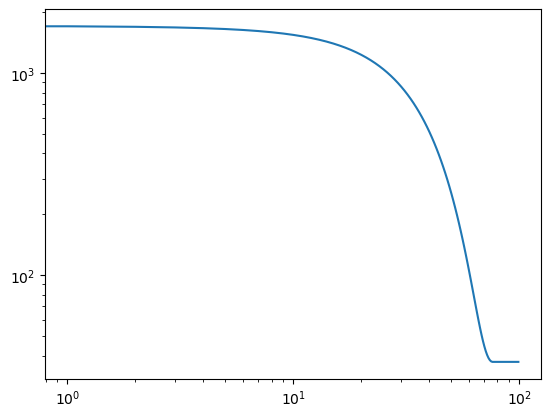

In [113]:
plt.loglog(mfista_solver_data["obj_vals"])
plt.plot()

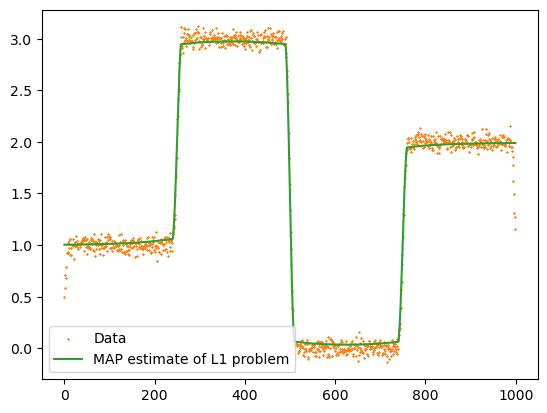

In [114]:
map_result = mfista_solver_data["result"]
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.plot(grid, map_result, label="MAP estimate of L1 problem", color="C2")
plt.legend()
plt.show()

# Sample the posterior of the Gaussian model

$$
-\log \pi(x)  = \left\{ \frac{1}{2 \sigma^2} \| x - y \|_2^2 + \frac{\lambda}{2} \| R x \|_2^2 \right\} + C
$$

In [115]:
# def gauss_posterior_summary(F, R, y, noise_var=1.0, reg_lambda=1e1):
#     """Computes posterior mean and stdev.
#     """
#     Q = sps.csc_matrix((1/noise_var)*(F.A.T @ F.A) + reg_lambda*(R.A.T @ R.A))
#     Q = jlinops.MatrixLinearOperator(Q)
#     Linv = jlinops.BandedCholeskyFactorInvOperator(Q)
#     mean = Linv.T @ (Linv @  ((1/noise_var)*F.T @ y) )

#     # Get diagonal entries of Qinv
#     Qinv = Linv.T @ Linv
#     var = jlinops.black_box_diagonal(Qinv)
#     stdev = np.sqrt(var)
#     return mean, stdev

In [116]:

# gauss_mu, gauss_sigmas = gauss_posterior_summary(F, R, noisy_signal, noise_var=noise_var, reg_lambda=1e4)

In [117]:
# #plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
# plt.plot(grid, gauss_mu, label="Mean vector", color="C2")
# plt.fill_between(grid, gauss_mu - 3*gauss_sigmas, gauss_mu + 3*gauss_sigmas, color="C4", alpha=0.5, label="3 sigma band")
# plt.legend()
# plt.show()

# Bayesian LASSO

In [10]:
class BayesianLASSOGibbsSampler:
    """Implements the Bayesian LASSO hierarchical sampler for the L1 problem.
    """

    def __init__(self, F, R, y, noise_var=1.0, reg_lambda_params={}):

        self.F = F
        self.R = R
        self.y = y
        self.noise_var = noise_var
        self.noise_stdev = np.sqrt(noise_var)
        self.reg_lambda_params = reg_lambda_params
        self.delta = reg_lambda_params["delta"]
        self.r = reg_lambda_params["r"]
        
        self.m = F.shape[0]
        self.k = R.shape[0]
        self.n = R.shape[1]

        self.last_x_solve = None



    def sample(self, n_samples, x0=None, n_burn=0, theta_tol=1e-2, reg_eta0=None, x_params={}, store_all=False):
        """Runs the Gibbs sampler.
        """

        # Initialize
        if x0 is None:
            x = np.zeros(self.F.shape[1])
        else:
            x = x0

        if reg_eta0 is None:
            reg_eta_sq = 1.0
        else:
            reg_eta_sq = reg_eta0

        # Create trackers
        x_tracker = StatsTracker(self.F.shape[1])
        theta_tracker = StatsTracker(self.R.shape[0])

        # For taking care of lambda udpates
        # lam_update_fn = lambda theta_ss_est: np.sqrt( 2*self.R.shape[0]/theta_ss_est )
        # theta_sum_tracker = StatsTracker((1,))
        # lam_hist = [lam]
        # theta_sums_all = []
        reg_eta_sq_hist = [reg_eta_sq]
        x_hist = []
        theta_hist = []

        # For tracking when gaussian draws are accepted
        x_draws_accepted = 0

        # Run the sampler
        for j in progress_bar(range(n_samples+n_burn)):

            # Update theta
            theta = self.sample_theta(x, reg_eta_sq, tol=theta_tol)

            # Update x
            x, accepted = self.sample_x(theta, x, **x_params)
            if j >= n_burn:
                if accepted:
                    x_draws_accepted += 1

            # Get new lambda
            reg_eta_sq = self.sample_reg_eta_sq(theta)
            reg_eta_sq_hist.append(reg_eta_sq)

            # Push to tracker
            if j >= n_burn:
                x_tracker.push(x)
                theta_tracker.push(theta)

                if store_all:
                    x_hist.append(x)
                    theta_hist.append(theta)

        
        results = {
            "x_tracker": x_tracker,
            "theta_tracker": theta_tracker,
            "reg_eta_sq_hist": np.asarray(reg_eta_sq_hist),
            "lam_hist": 1.0/np.asarray(reg_eta_sq_hist),
            "x_draws_acceptance_rate": x_draws_accepted/n_samples,
        }

        if store_all:
            results["x_hist"] = x_hist
            results["theta_hist"] = theta_hist


        return results
    


    def sample_x(self, theta, x_old, method="rjpo", *args, **kwargs):

        if method == "rjpo":

            return self.sample_x_rjpo(theta, x_old, *args, **kwargs)
        
        elif method == "sparse_cholesky":

            return self.sample_x_sparse_cholesky(theta), True
        
        else: 

            raise NotImplementedError



    def sample_x_rjpo(self, theta, x_old, cg_maxits=None, cg_tol=1e-3, ar_step=True):
        """Given local variances theta, draws a sample for x.
        """

        # Update using RJPO method
        if cg_maxits is None:
            cg_maxits = self.n
        
        # Sample eta
        Ls = [ (1.0/self.noise_stdev)*self.F.T, self.R.T @ jlinops.MatrixLinearOperator(sps.diags(1.0/np.sqrt(theta))) ]
        Qmu = (1.0/self.noise_var)*(self.F.T @ self.y)
        eta = self.sample_eta(Qmu, Ls)

        # Solve system approximately
        Q = (1.0/self.noise_var)*(self.F.T @ self.F) + (self.R.T @ ( jlinops.MatrixLinearOperator(sps.diags(1.0/theta)) @ self.R ) )
        if self.last_x_solve is None:
            warmstart = None
        else:
            warmstart = - self.last_x_solve
        x_approx, _ = cg(Q, eta, x0=warmstart, maxiter=cg_maxits, tol=cg_tol)
        
        if not ar_step:
            return x_approx, True

        residual = eta - (Q @ x_approx)

        # Accept or reject
        log_uniform = np.log(np.random.uniform())
        log_accept = np.amin([0.0, -residual.T @ (x_old - x_approx)])

        if log_uniform < log_accept:
            x = x_approx
            accepted = True
        else:
            x = x_old
            accepted = False

        self.last_x_solve = x

        return x, accepted



    def sample_x_sparse_cholesky(self, theta):
        """Given local variances theta, draws a sample for x.
        """

        Q = (1.0/self.noise_var)*(self.F.A.T @ self.F.A) + (self.R.A.T @ ( sps.diags(1.0/theta) @ self.R.A ) )

        # # Bad way
        # Qinv = np.linalg.inv(Q.toarray())
        # mean = Qinv @ ((1.0/self.noise_var)*self.F.T @ self.y )
        # sample = np.random.multivariate_normal(mean, Qinv)

        # Good way
        Q = sps.csc_matrix(Q)
        Q = jlinops.MatrixLinearOperator(Q)
        Linv = jlinops.BandedCholeskyFactorInvOperator(Q)
        mean = Linv.T @ (Linv @ ((1.0/self.noise_var)*self.F.T @ self.y ) )
        sample = mean + ( Linv.T @ np.random.normal(size=Q.shape[0]) )

        return sample



    def sample_theta(self, x, eta_sq, tol=1e-5):
        """Given x, draws a sample for the thetas.
        """

        # Get Rx
        Rx = self.R @ x

        # Make output array
        sample = np.zeros(self.R.shape[0])

        # Need to check where Rx is close to zero, so we can sample from exponential there instead
        idx_too_small = np.where(np.abs(Rx) < tol)
        idx_fine = np.where(np.abs(Rx) >= tol)

        # Break into two parts
        Rx_too_small = Rx[idx_too_small]
        Rx_fine = Rx[idx_fine]

        # For the components near zero, sample from the gamma
        reg_lambda = 1.0/eta_sq
        theta_from_too_small = np.random.gamma(0.5, scale=2.0/reg_lambda, size=len(Rx_too_small))

        # For the components not near zero, sample from the inverse Gaussian
        mu = np.sqrt(reg_lambda)/np.abs(Rx_fine)
        ig_lam = reg_lambda
        theta_from_fine = 1.0/np.random.wald(mu, scale=ig_lam)

        # Put all into one array
        sample[idx_too_small] = theta_from_too_small
        sample[idx_fine] = theta_from_fine

        #sample += 1e-10
        assert np.all(sample > 0), "some thetas are no positive!"
        
        return sample


    def sample_eta(self, Qmu, Ls):
        """Draws a sample from $\mathcal{N}(Q \mu, Q)$. Here $Q$ is assumed to be of the form $Q = \sum_{i=1}^p L_i^T L_i$,
        where the $L_i$ are collected in Ls."""
         
        # Draw sample with correct covariance
        sample = np.zeros(self.n)
        for L in Ls:
            sample += L.matvec( np.random.normal(size=L.shape[1]) )

        # Add mean
        sample += Qmu
        
        return sample
    

    def sample_reg_eta_sq(self, theta):
        """Samples from the conditional for the regularization parameter.
        """
        
        shape_param = self.k + self.r - 1
        rate_param = self.delta + 0.5*theta.sum()
        # print(rate_param)

        #xsi = np.random.gamma(shape_param, scale=rate_param)
        #new_reg_eta_sq = 1.0/xsi

        new_reg_eta_sq = invgamma.rvs(shape_param, scale=rate_param)
        # new_reg_eta = np.random.invgamma()
        

        return new_reg_eta_sq

In [11]:
reg_lambda_params = {
    "r": 1.0,
    "delta": 1e-4, 
}

In [12]:
lasso_sampler = BayesianLASSOGibbsSampler(F, R, noisy_signal, noise_var=noise_var, reg_lambda_params=reg_lambda_params)

In [13]:
sampling_result = lasso_sampler.sample(n_samples=5000, n_burn=1000, reg_eta0=1.0, x_params={"method":"sparse_cholesky"}, store_all=True)

In [14]:
sampling_result.keys()

dict_keys(['x_tracker', 'theta_tracker', 'reg_eta_sq_hist', 'lam_hist', 'x_draws_acceptance_rate', 'x_hist', 'theta_hist'])

In [27]:
# sampling_result = lasso_sampler.sample(n_samples=500, n_burn=500, reg_eta0=1.0, x_params={"cg_maxits":3000, "cg_tol":1e-3, "ar_step":False})

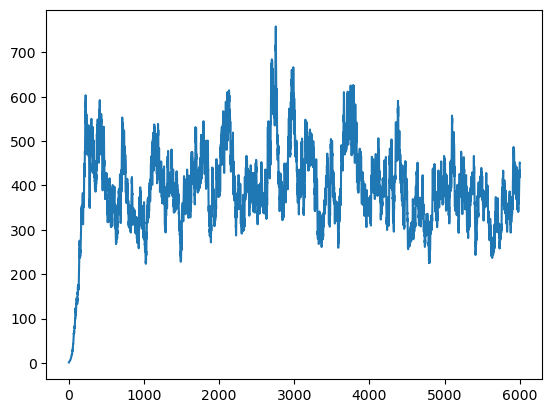

In [15]:
plt.plot(sampling_result["lam_hist"])
plt.show()

In [16]:
sampling_result["x_draws_acceptance_rate"]

1.0

In [17]:
sampling_result["lam_hist"][-1]

450.96017888715505

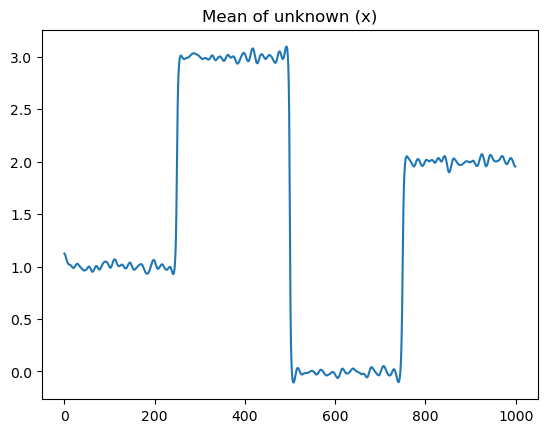

In [18]:
plt.plot(sampling_result["x_tracker"].mean())
plt.title("Mean of unknown (x)")
plt.show()

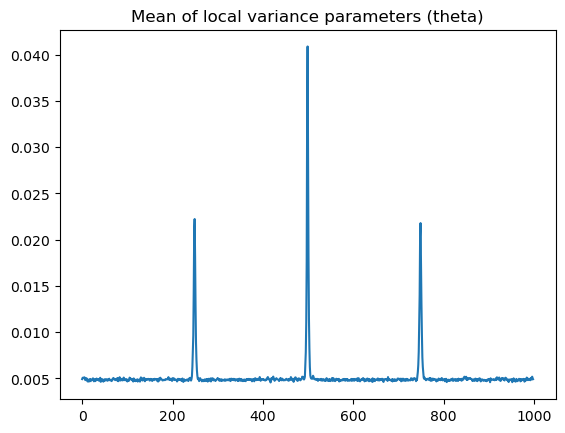

In [32]:
plt.plot(sampling_result["theta_tracker"].mean())
plt.title("Mean of local variance parameters (theta)")
plt.show()

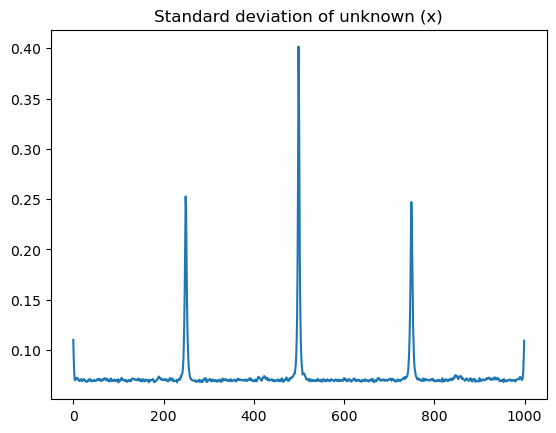

In [33]:
plt.plot(sampling_result["x_tracker"].stdev())
plt.title("Standard deviation of unknown (x)")
plt.show()

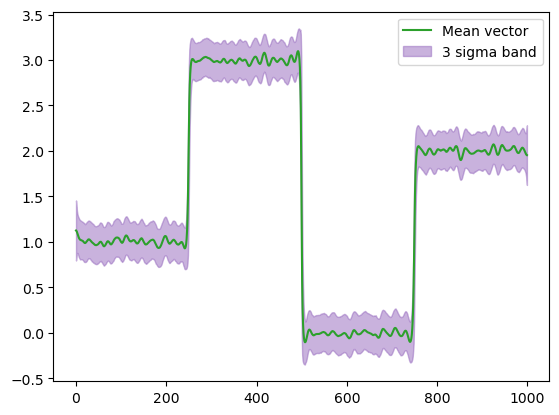

In [34]:
#plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
mu, stdev = sampling_result["x_tracker"].mean(), sampling_result["x_tracker"].stdev()
plt.plot(grid, mu, label="Mean vector", color="C2")
plt.fill_between(grid, mu - 3*stdev, mu + 3*stdev, color="C4", alpha=0.5, label="3 sigma band")
plt.legend()
plt.show()

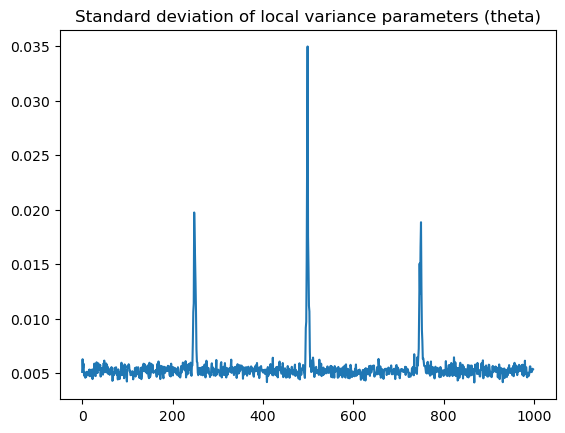

In [138]:
plt.plot(sampling_result["theta_tracker"].stdev())
plt.title("Standard deviation of local variance parameters (theta)")
plt.show()

# Comparison with other methods

In [139]:
# Do MAP again
f = sampi.GaussianDataLikelihood(F, noisy_signal, v=noise_var)
g = sampi.TV1DPenalty(n, boundary="none", reg_lam=sampling_result["lam_hist"][-1])
obj = sampi.CompositeModelObjectiveFunction(f, g)
solver = sampi.MFISTASolver(obj)
mfista_solver_data = solver.solve(iterations=500, L=None)

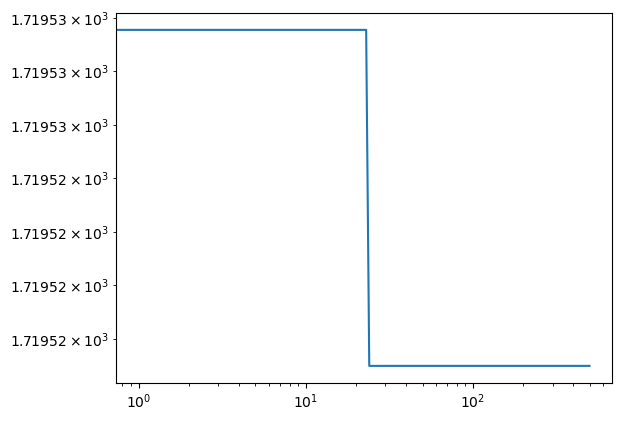

In [140]:
plt.loglog(mfista_solver_data["obj_vals"])
plt.show()

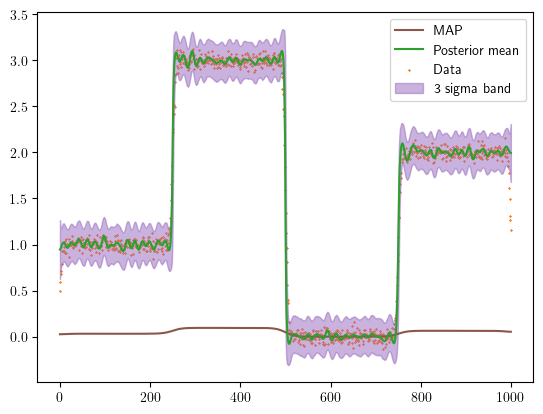

In [192]:
# Get MAP point for the lambda chosen during sampling
map_est = mfista_solver_data["result"]
#plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)

mu, stdev = sampling_result["x_tracker"].mean(), sampling_result["x_tracker"].stdev()

plt.plot(grid, map_est, label="MAP", color="C5")
plt.plot(grid, mu, label="Posterior mean", color="C2")
plt.scatter(grid, noisy_signal, marker="x", label="Data", color="C1", alpha=1.0, s=0.5)
plt.fill_between(grid, mu - 3*stdev, mu + 3*stdev, color="C4", alpha=0.5, label="3 sigma band")
plt.legend()
plt.show()


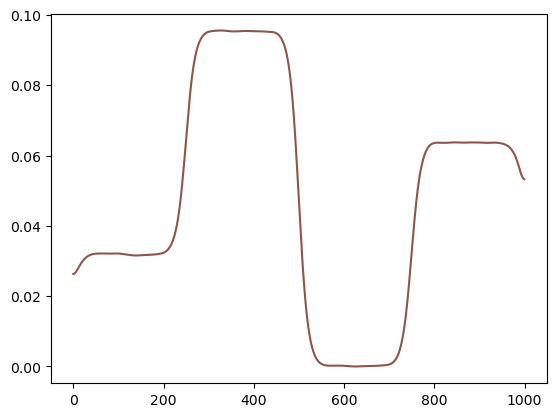

In [142]:
# plt.plot(grid, map_est, label="MAP", color="C5")
# plt.show()

# Plots for paper

In [19]:
import matplotlib as mpl

In [20]:
dcolors = {
    "dartmouth_green": "#00693e", 
    "forest_green": "#12312b",
    "river_blue": "#267aba",
    "autumn_brown": "#643c20",
    "bonfire_red": "#9d162e",
    "river_navy": "#003c73",
    "spring_green": "#c4dd88",
    "rich_spring_green": "#a5d75f",
    "summer_yellow": "#f5dc69",
    "bonfire_orange": "#ffa00f",
    "tuck_orange": "#e32d1c",
    "web_violet": "#8a6996",
    "midnight_black": "#000000",
}

In [21]:
mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
mpl.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{bm}')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


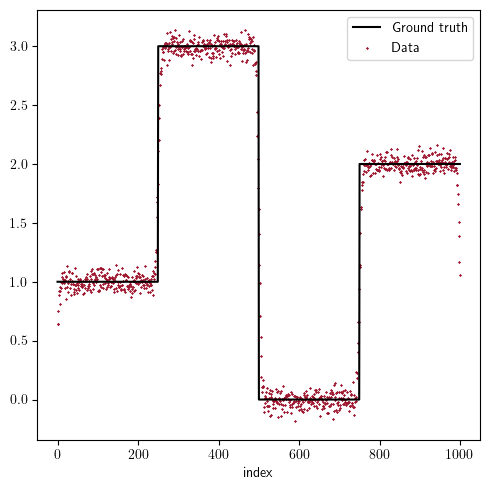

In [22]:
plt.figure(figsize=(5,5))
plt.plot(grid, ground_truth, label="Ground truth", color=dcolors["midnight_black"])
plt.scatter(grid, noisy_signal, marker="x", label="Data", color=dcolors["bonfire_red"], alpha=1.0, s=0.5)
#plt.title("Deblurring problem data")
plt.xlabel("index")
plt.legend()

plt.tight_layout()
plt.savefig("real_deblurring_data.png", dpi=250, bbox_inches="tight")
plt.savefig("real_deblurring_data.eps")

plt.show()

In [23]:
z = np.asarray(sampling_result["x_hist"])
lower_5 = np.quantile(z, 0.05, axis=0)
upper_95 = np.quantile(z, 0.95, axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


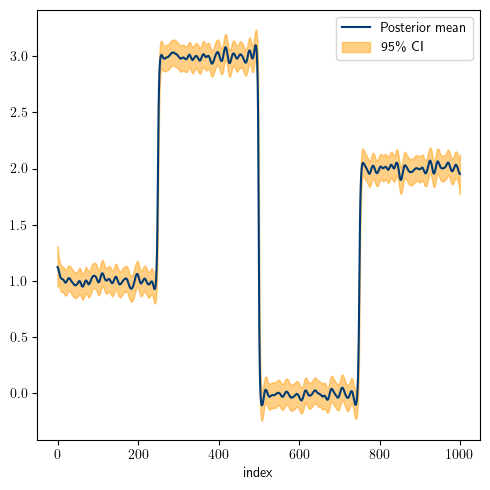

In [25]:
plt.figure(figsize=(5,5))
plt.plot(grid, sampling_result["x_tracker"].mean(), color=dcolors["river_navy"], label="Posterior mean")
plt.fill_between(grid, lower_5, upper_95, alpha=0.5, color=dcolors["bonfire_orange"], label="95\\% CI")
#plt.title("$\\bm x$")
plt.xlabel("index")
plt.legend()

plt.tight_layout()
plt.savefig("real_deblurring_x_result.png", dpi=250, bbox_inches="tight")
plt.savefig("real_deblurring_x_result.eps")

plt.show()

In [26]:
z = np.asarray(sampling_result["theta_hist"])
lower_5 = np.quantile(z, 0.05, axis=0)
upper_95 = np.quantile(z, 0.95, axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


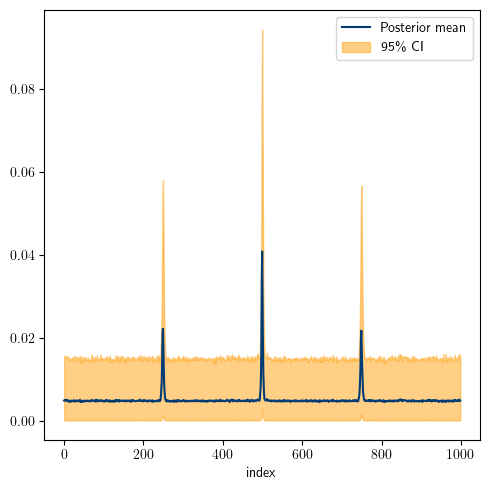

In [27]:
plt.figure(figsize=(5,5))
plt.plot(grid[:-1], sampling_result["theta_tracker"].mean(), color=dcolors["river_navy"], label="Posterior mean")
plt.fill_between(grid[:-1], lower_5, upper_95, alpha=0.5, color=dcolors["bonfire_orange"], label="95\\% CI")
#plt.title("$\\boldsymbol{ \\tau }^2$")
plt.xlabel("index")
plt.legend()


plt.tight_layout()
plt.savefig("real_deblurring_theta_result.png", dpi=250, bbox_inches="tight")
plt.savefig("real_deblurring_theta_result.eps")


plt.show()

# again but longer

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


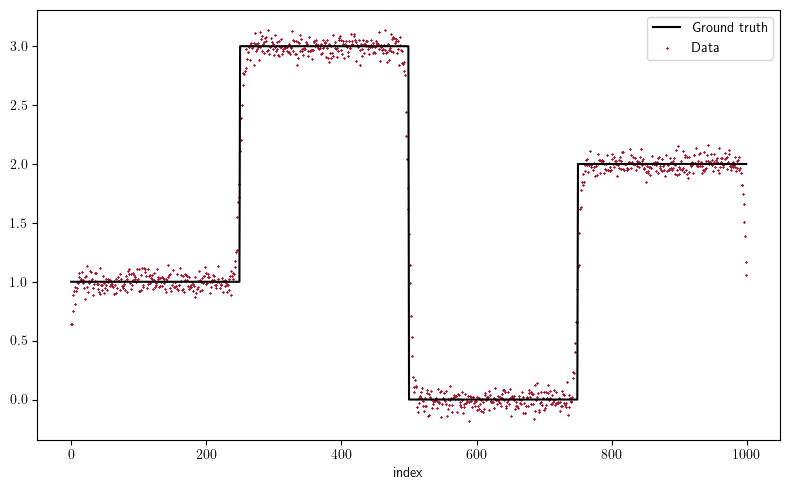

In [28]:
plt.figure(figsize=(8,5))
plt.plot(grid, ground_truth, label="Ground truth", color=dcolors["midnight_black"])
plt.scatter(grid, noisy_signal, marker="x", label="Data", color=dcolors["bonfire_red"], alpha=1.0, s=0.5)
#plt.title("Deblurring problem data")
plt.xlabel("index")
plt.legend()

plt.tight_layout()
plt.savefig("long_real_deblurring_data.png", dpi=250, bbox_inches="tight")
plt.savefig("long_real_deblurring_data.eps")

plt.show()

In [29]:
z = np.asarray(sampling_result["lam_hist"])
lower_5 = np.quantile(z, 0.05, axis=0)
upper_95 = np.quantile(z, 0.95, axis=0)

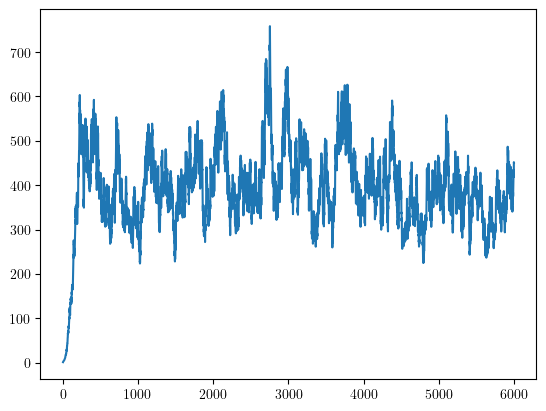

In [30]:
plt.plot( z )
plt.show()

In [31]:
1.0/np.mean(z[1000:])

0.002494514279747214

In [32]:
z = np.asarray(sampling_result["x_hist"])
lower_5 = np.quantile(z, 0.05, axis=0)
upper_95 = np.quantile(z, 0.95, axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


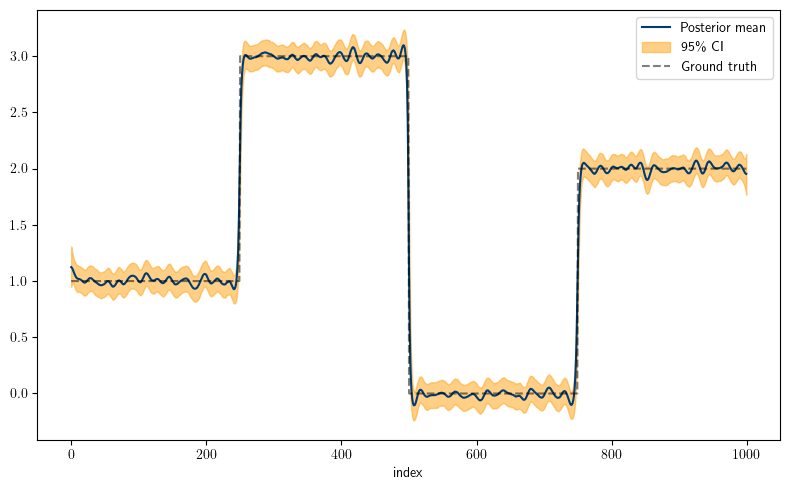

In [33]:
plt.figure(figsize=(8,5))
plt.plot(grid, sampling_result["x_tracker"].mean(), color=dcolors["river_navy"], label="Posterior mean")
plt.fill_between(grid, lower_5, upper_95, alpha=0.5, color=dcolors["bonfire_orange"], label="95\\% CI")
#plt.title("$\\bm x$")
plt.plot(grid, ground_truth, color=dcolors["midnight_black"], ls="--", label="Ground truth", alpha=0.5)
plt.xlabel("index")
plt.legend()

plt.tight_layout()
plt.savefig("long_real_deblurring_x_result.png", dpi=250, bbox_inches="tight")
plt.savefig("long_real_deblurring_x_result.eps")

plt.show()

In [34]:
z = np.asarray(sampling_result["theta_hist"])
lower_5 = np.quantile(z, 0.05, axis=0)
upper_95 = np.quantile(z, 0.95, axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


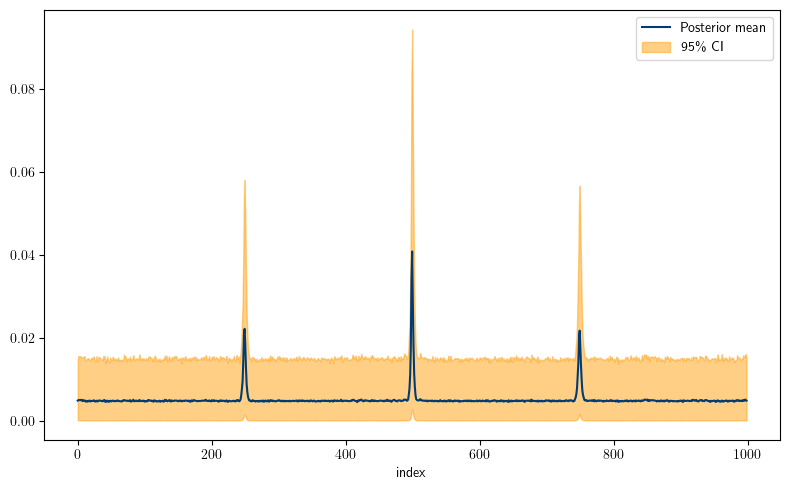

In [35]:
plt.figure(figsize=(8,5))
plt.plot(grid[:-1], sampling_result["theta_tracker"].mean(), color=dcolors["river_navy"], label="Posterior mean")
plt.fill_between(grid[:-1], lower_5, upper_95, alpha=0.5, color=dcolors["bonfire_orange"], label="95\\% CI")
#plt.title("$\\boldsymbol{ \\tau }^2$")
plt.xlabel("index")
plt.legend()


plt.tight_layout()
plt.savefig("long_real_deblurring_theta_result.png", dpi=250, bbox_inches="tight")
plt.savefig("long_real_deblurring_theta_result.eps")


plt.show()

In [36]:
z = np.asarray(sampling_result["x_hist"])
lower_5 = np.quantile(z, 0.05, axis=0)
upper_95 = np.quantile(z, 0.95, axis=0)

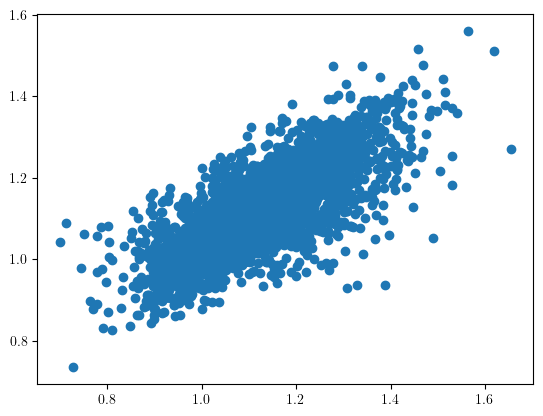

In [37]:
plt.scatter(z[:,0], z[:,1])
plt.show()

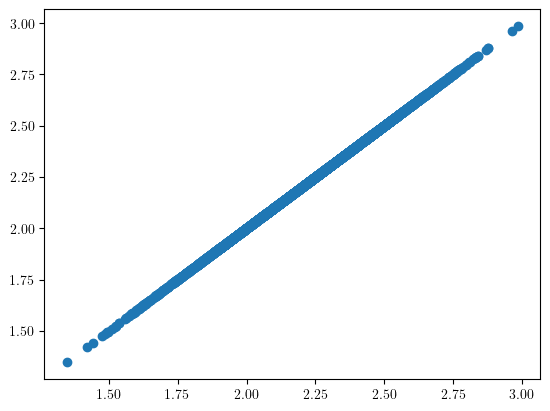

In [38]:
idx = 250
plt.scatter(z[:,idx], z[:,idx])
plt.show()

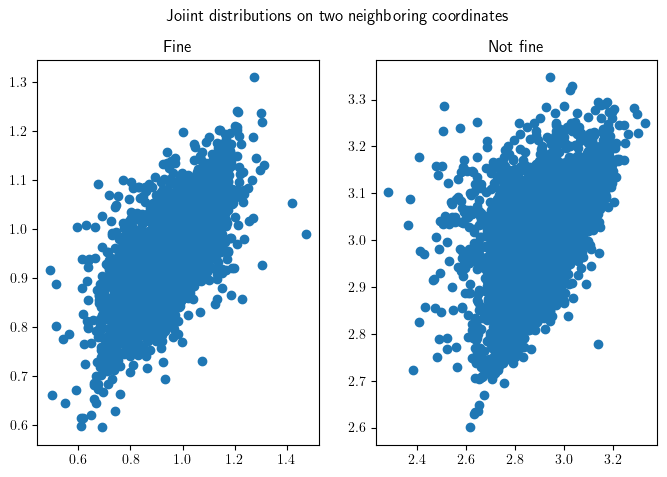

In [293]:
fig, axs = plt.subplots(1, 2, figsize=(8, 5))

axs[0].set_title("Fine")
axs[0].scatter(z[:,0], z[:,1])
axs[]


axs[1].set_title("Not fine")
idx = 253
axs[1].scatter(z[:,idx], z[:,idx+1])

fig.suptitle("Joiint distributions on two neighboring coordinates")

plt.show()

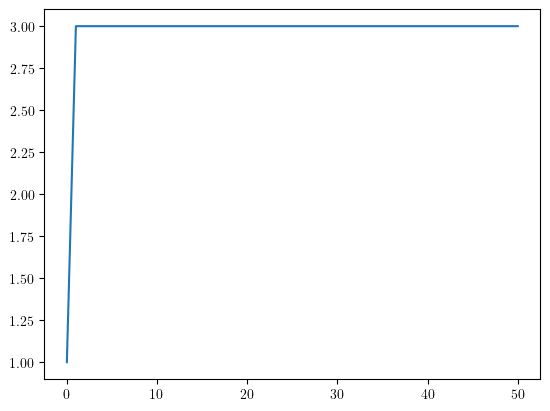

In [289]:
plt.plot(ground_truth[249:300])
plt.show()

# ESS per pixel

In [278]:
import arviz as az

In [294]:
az.ess(z)

26052.7919976418

In [310]:
zdata = az.convert_to_dataset(z[None,:,:])

In [311]:
ess_res = az.ess(zdata)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


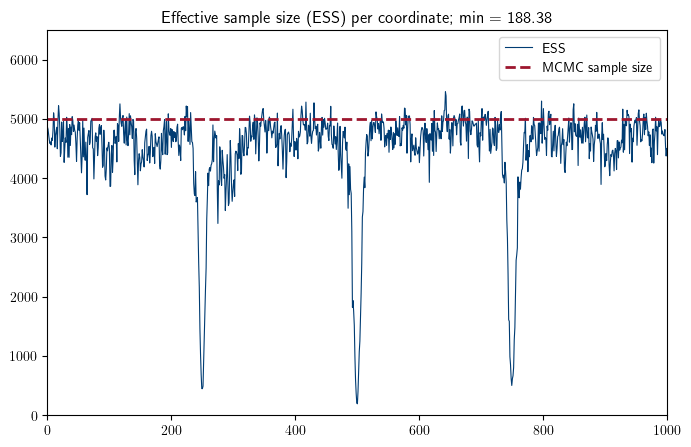

In [362]:
plt.figure(figsize=(8,5))
plt.plot(ess_res["x"].values, color=dcolors["river_navy"], lw=0.8, label="ESS")
minval = np.amin(ess_res["x"].values)
plt.title(f"Effective sample size (ESS) per coordinate;   min = {minval:.2f}")
plt.hlines(5000, xmin=0, xmax=1000, ls="--", color=dcolors["bonfire_red"], lw=2, label="MCMC sample size")
plt.xlim(0, 1000)
plt.ylim(0, 6500)
plt.legend(loc="upper right")
plt.savefig("lasso_ess.png", dpi=250, bbox_inches="tight")
plt.savefig("lasso_ess.eps", bbox_inches="tight")
plt.show()

In [357]:
np.amin(ess_res["x"].values)

188.37974854345487

In [346]:
z = np.asarray(sampling_result["x_hist"])

<Axes: title={'center': 'x\n0'}>

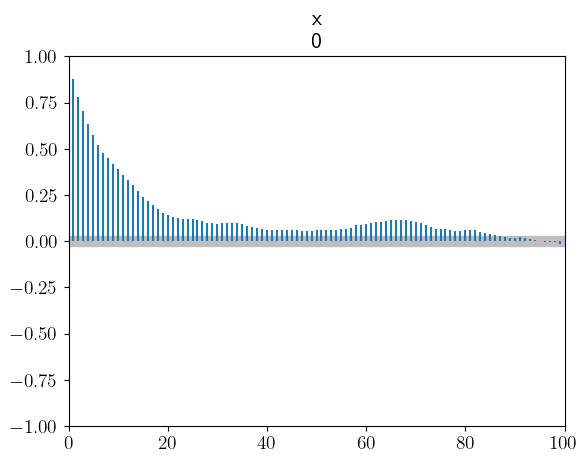

In [354]:
az.plot_autocorr( z[:, 500] )

In [347]:
z.shape

(5000, 1000)

In [314]:
zdata

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 5000, x_dim_0: 1000)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 4993 4994 4995 4996 4997 4998 4999
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    x        (chain, draw, x_dim_0) float64 0.8627 0.7758 0.8811 ... 1.969 1.918
Attributes:
    created_at:     2024-02-17T23:55:55.110276
    arviz_version:  0.17.0

In [338]:
az.plot_autocorr(zdata["x_dim_0"][0])

ValueError: cannot create a Dataset from a DataArray with the same name as one of its coordinates

In [313]:
az.autocorr(zdata)

AttributeError: 'Dataset' object has no attribute 'shape'

/Users/jonathanlindbloom/opt/miniconda3/envs/jlinops/lib/python3.11/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1000) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'x\n0, 0'}>,
        <Axes: title={'center': 'x\n0, 1'}>,
        <Axes: title={'center': 'x\n0, 2'}>,
        <Axes: title={'center': 'x\n0, 3'}>],
       [<Axes: title={'center': 'x\n0, 4'}>,
        <Axes: title={'center': 'x\n0, 5'}>,
        <Axes: title={'center': 'x\n0, 6'}>,
        <Axes: title={'center': 'x\n0, 7'}>],
       [<Axes: title={'center': 'x\n0, 8'}>,
        <Axes: title={'center': 'x\n0, 9'}>,
        <Axes: title={'center': 'x\n0, 10'}>,
        <Axes: title={'center': 'x\n0, 11'}>],
       [<Axes: title={'center': 'x\n0, 12'}>,
        <Axes: title={'center': 'x\n0, 13'}>,
        <Axes: title={'center': 'x\n0, 14'}>,
        <Axes: title={'center': 'x\n0, 15'}>],
       [<Axes: title={'center': 'x\n0, 16'}>,
        <Axes: title={'center': 'x\n0, 17'}>,
        <Axes: title={'center': 'x\n0, 18'}>,
        <Axes: title={'center': 'x\n0, 19'}>],
       [<Axes: title={'center': 'x\n0, 20'}>,
        <Axes: title={'center': 'x\n0, 

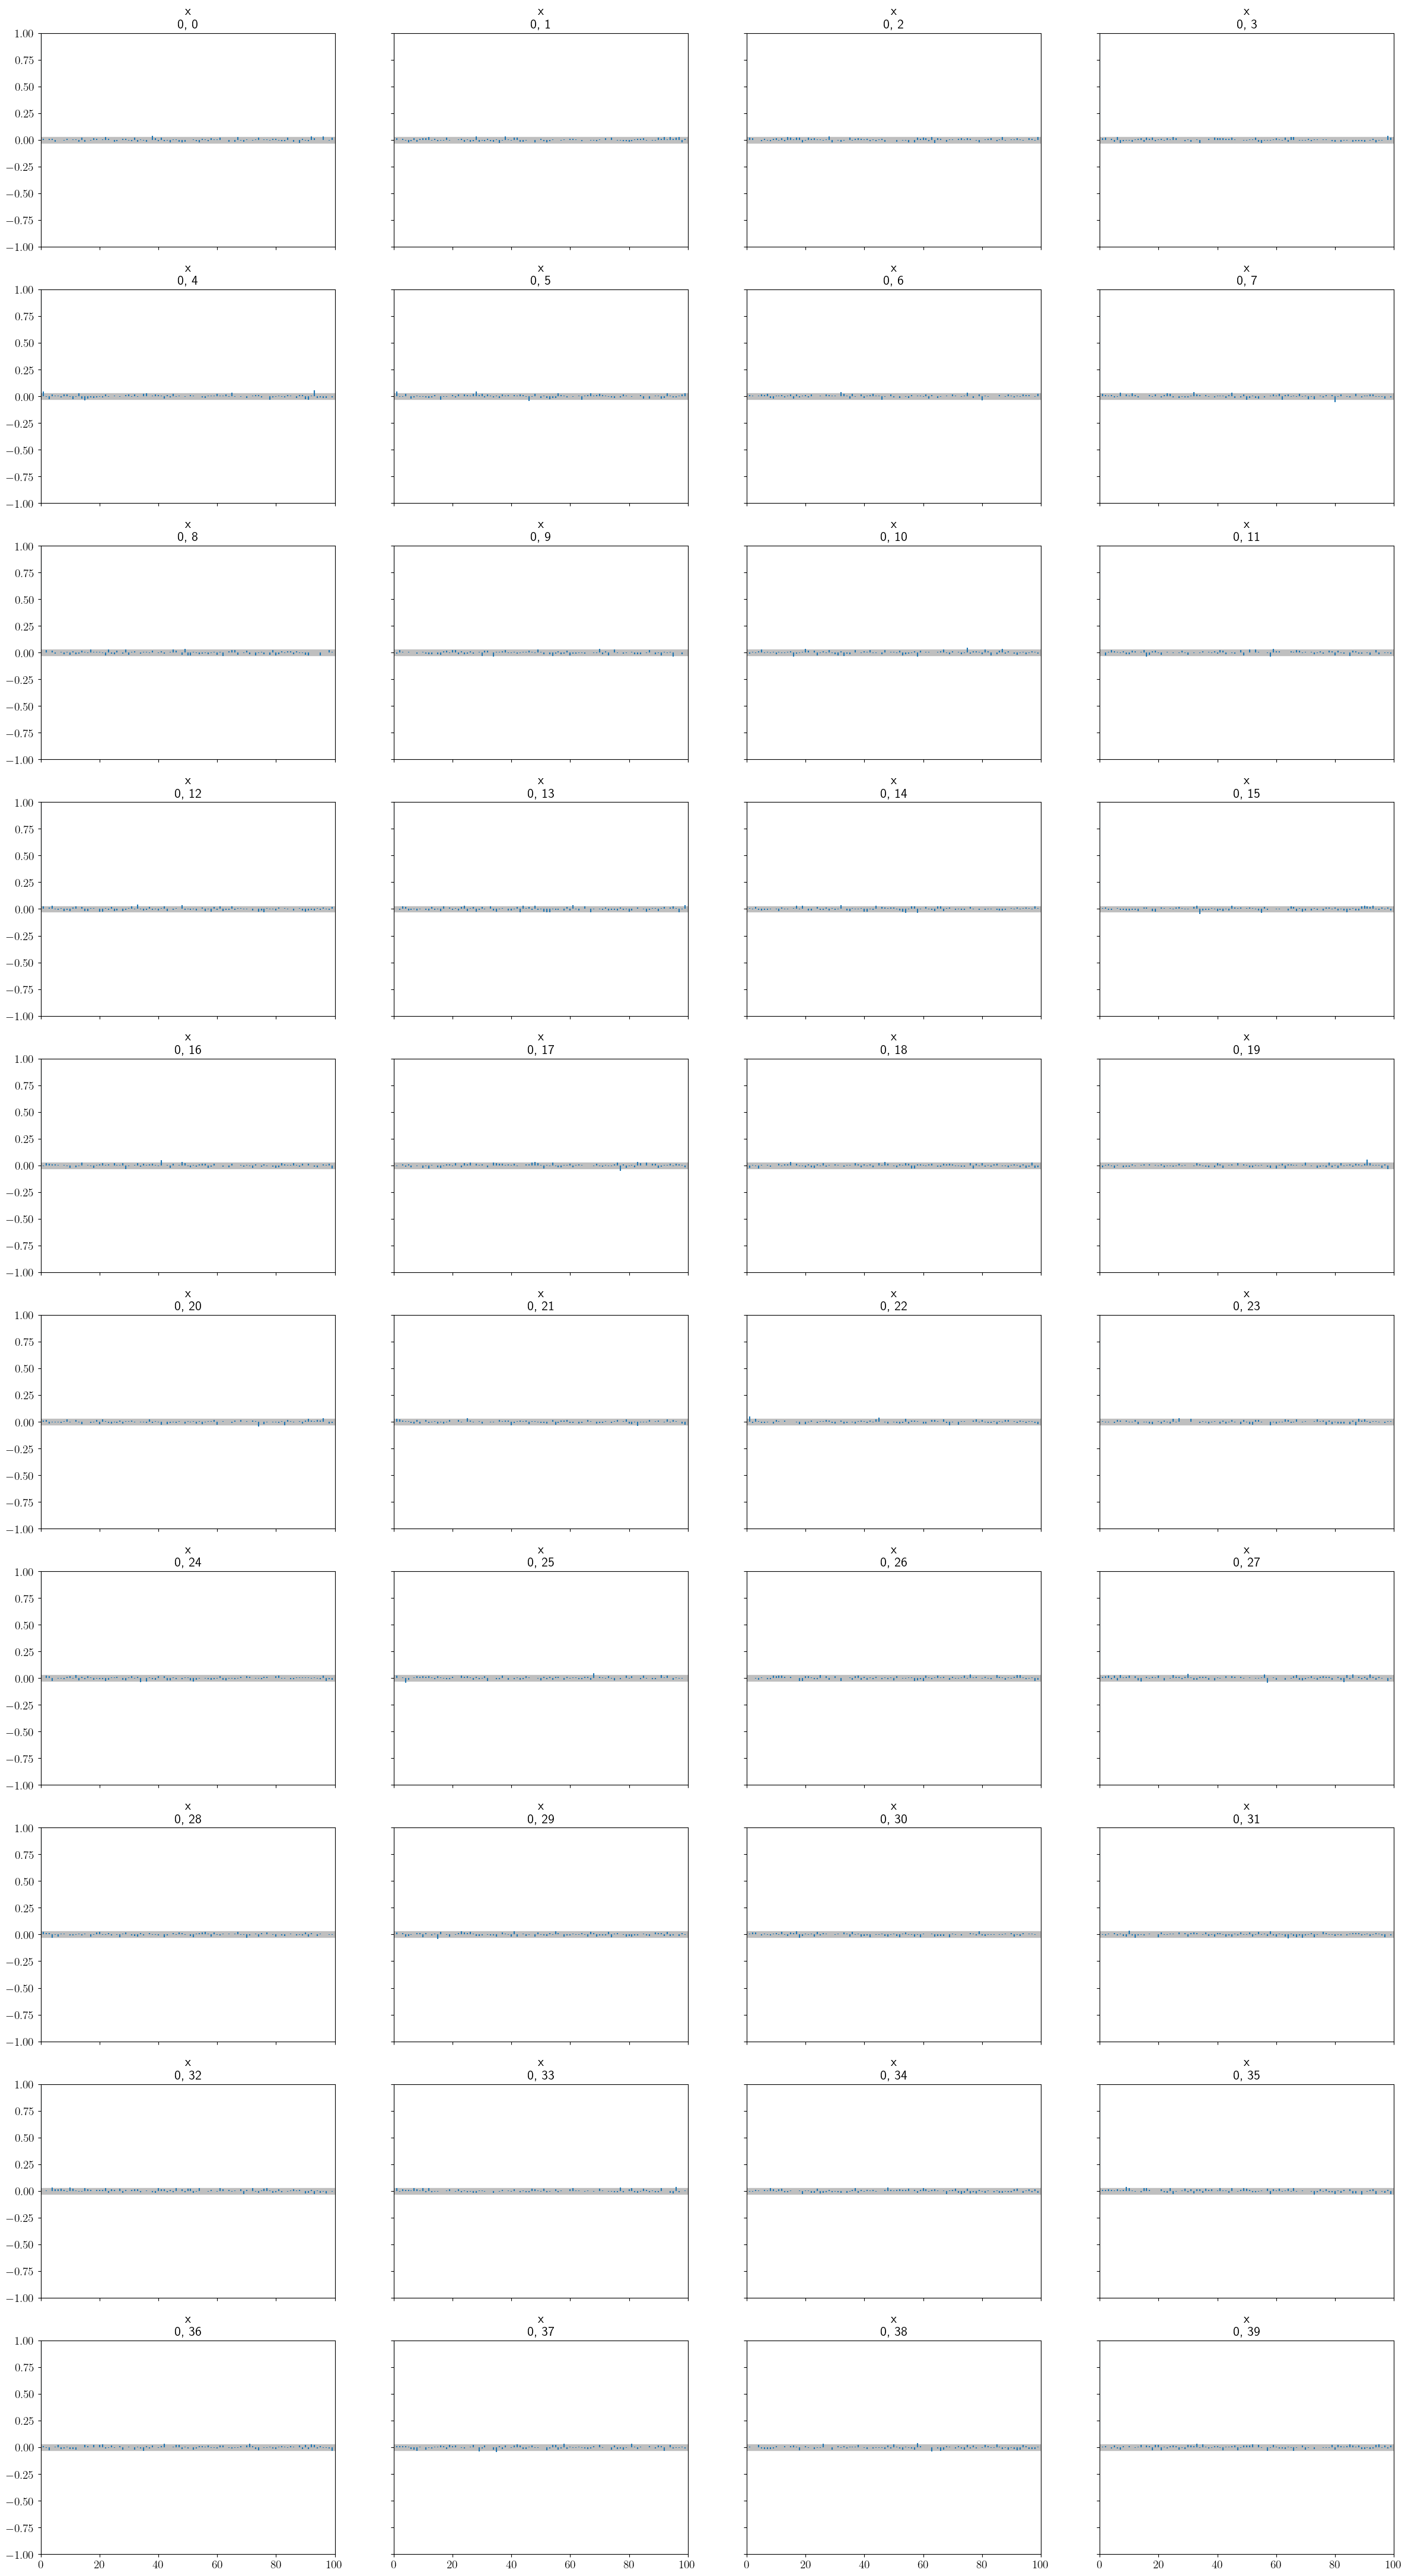

In [315]:
az.plot_autocorr(zdata)

In [ ]:
idx = 250
plt.scatter(z[:,idx], z[:,idx])
plt.show()

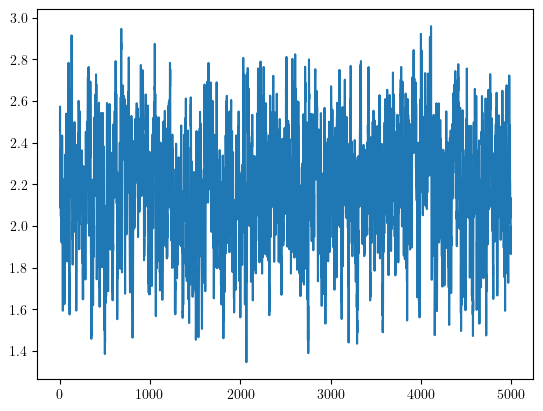

In [277]:
plt.plot(z[:,idx])
plt.show()

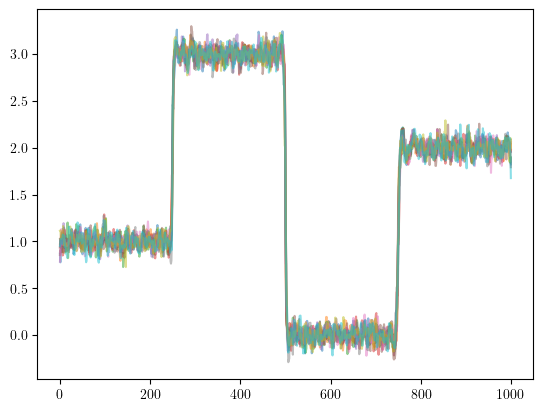

In [274]:
for j in range(10):
    plt.plot(z[-j*10,:], alpha=0.5)
    
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(grid, sampling_result["x_tracker"].mean(), color=dcolors["river_navy"], label="Posterior mean")
plt.fill_between(grid, lower_5, upper_95, alpha=0.5, color=dcolors["bonfire_orange"], label="95\% CI")
#plt.title("$\\bm x$")
plt.plot(grid, ground_truth, color=dcolors["midnight_black"], ls="--", label="Ground truth", alpha=0.5)
plt.xlabel("index")
plt.legend()

plt.tight_layout()
plt.savefig("long_real_deblurring_x_result.png", dpi=250, bbox_inches="tight")
plt.savefig("long_real_deblurring_x_result.eps")

plt.show()

In [255]:
len(sampling_result["lam_hist"])

6001

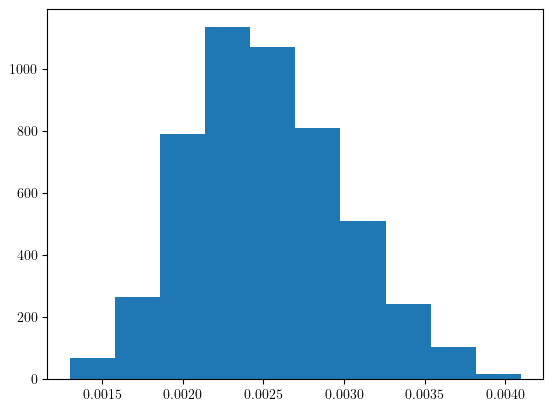

In [256]:
plt.hist(1.0/sampling_result["lam_hist"][1000:])
plt.show()

In [258]:
np.sqrt(np.mean(1.0/sampling_result["lam_hist"][1000:]))

0.050199481277871764